In [43]:
# imports 

%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

Populating the interactive namespace from numpy and matplotlib


# Outlier Detection Algorithms 1 - Using Supervised Learning Algorithms
In this part of the notebook we will use supervised learning algorithms in order to find outliers. <br>
We will use one-class SVM and a **upervised** Random Forest. <br>
Therefore, this notebook can also be used to learn about the supervised learning algorithms: SVM and RF. <br>
We will see the output for a simple dataset, and you can then try these algorithms on your own dataset. <br> <br>

We will use the functions: <br>
- One-class SVM: https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM <br>
- Supervised Random Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html <br>

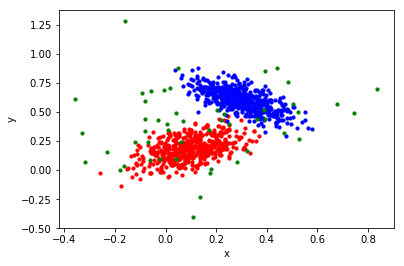

In [5]:
# simulate a simple dataset, and add some outliers to it

size = 500
mean_1 = np.array([0.1, 0.2])
cov_1 = np.array([[0.01, 0.005], [0.005, 0.01]])
X1 = np.random.multivariate_normal(mean_1, cov_1, size=size)

mean_2 = np.array([0.3, 0.6])
cov_2 = np.array([[0.01, -0.007], [-0.007, 0.01]])
X2 = np.random.multivariate_normal(mean_2, cov_2, size=size)

# outliers
mean_3 = np.array([0.2, 0.4])
cov_3 = np.array([[0.1, 0], [0, 0.1]])
X3 = np.random.multivariate_normal(mean_3, cov_3, size=size/10) # size is smaller, because these are outliers!

plt.scatter(X1[:, 0], X1[:, 1], c="r", s=10)
plt.scatter(X2[:, 0], X2[:, 1], c="b", s=10)
plt.scatter(X3[:, 0], X3[:, 1], c="g", s=10)
plt.xlabel("x")
plt.ylabel("y")

(525, 2) (525, 2)


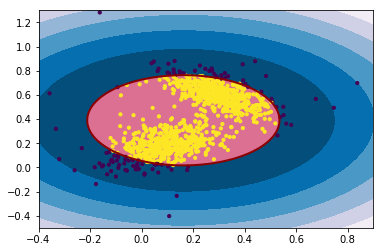

In [20]:
# let's examine the one-class SVM. 
# we will break the dataset into a training and a test set in order to optimize over the hyper-parameters.
# read about one-class SVM here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM

X = np.concatenate([X1, X2, X3])

# shuffle the dataset before dividing it into training and test set
choose_indices = numpy.arange(len(X))
np.random.shuffle(choose_indices)
train_indices = choose_indices[:len(choose_indices)/2]
test_indices = choose_indices[len(choose_indices)/2:]
X_train = X[train_indices, :]
X_test = X[test_indices, :]
print X_train.shape, X_test.shape

# train a one-class SVM. Start with some hyper parameters
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.01)
clf.fit(X_train)

# now we can predict for all the objects whether they belong to the class (1) or not (-1).
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# plot the decision boundries of the algorithm - where is the boundry between inliers and outliers?
xx, yy = np.meshgrid(np.linspace(-0.4, 0.9, 500), np.linspace(-0.5, 1.3, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

# plot the sample again, and color the points according to whether they are classified as inliers or outliers
# yellow are inliers, purple are outliers
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred_train, s=10)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test, s=10)

### Question to student: 
Why do you think that the outlier detection did not work well? How can we improve it? <br>
Play with different hyper-parameters for the SVM. How do they affect the outliers that you find? <br>
Try to simulate a simpler and a more complex dataset. What type of outliers can you detect? <br>

In [27]:
# we will now try to train a Random Forest to distinuguish between the two classes, and then we will see 
# whether the prediction probability can help us find the outliers. 

# we need to define labels, since we use supervised RF and we have two classes of objects
y1 = np.zeros(len(X1))
y2 = np.ones(len(X2))
y3 = np.random.choice([0, 1], size=len(X3)) # assign random classes to outliers

y = np.concatenate([y1, y2, y3])
X = np.concatenate([X1, X2, X3])
print X.shape, y.shape

# divide the data into a training and a test set
choose_indices = numpy.arange(len(X))
np.random.shuffle(choose_indices)
train_indices = choose_indices[:len(choose_indices)/2]
test_indices = choose_indices[len(choose_indices)/2:]

X_train = X[train_indices, :]
X_test = X[test_indices, :]
y_train = y[train_indices]
y_test = y[test_indices]
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

# train a supervised RF to separate between the two groups
# number of trees: 50
clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train, y_train)

(1050, 2) (1050,)
(525, 2) (525, 2) (525,) (525,)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
# let's examine the prediction of the RF on the training and the test set
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# get the classification accuracy on the training and the test set
score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)
print "accuracy on training set: ", score_train
print "accuracy on test set: ", score_test

accuracy on training set:  1.0
accuracy on test set:  0.975238095238


### This is an amazing accuracy on test set!!!!!! :)
Now let us plot the decision boundaries of the classification probability, and then examine the type of outliers we find. 

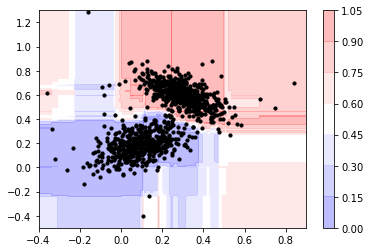

In [33]:
# first create the decision boundries of the RF - this corresponds to the probability of the prediction

xx, yy = np.meshgrid(np.linspace(-0.4, 0.9, 500), np.linspace(-0.5, 1.3, 500))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.3)
plt.colorbar()

# plot the measurements
plt.scatter(X_train[:, 0], X_train[:, 1], c="k", s=10)
plt.scatter(X_test[:, 0], X_test[:, 1], c="k", s=10)


### outliers:
In order to detect outliers, we must define a probability threshold with which we will define outliers. <br>
The classification probability of p=0 corresponds to a probability of 1 for class A. <br>
The classification probability of p=1 corresponds to a probability of 1 for class B. <br>
Therefore, we will define outliers as objects that have a probability around 0.5.

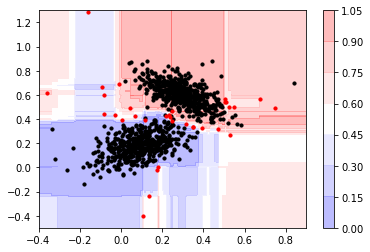

In [42]:
probability_threshold = 0.3 # degree of outliers we will try to find
proba_max = 0.5 + probability_threshold
proba_min = 0.5 - probability_threshold
# everything between these probabilities will be defined as an outlier!

y_proba_train = clf.predict_proba(X_train)[:, 0]
y_proba_test = clf.predict_proba(X_test)[:, 0]

# plot the decision boundries
xx, yy = np.meshgrid(np.linspace(-0.4, 0.9, 500), np.linspace(-0.5, 1.3, 500))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.3)
plt.colorbar()

# plot the objects - black will be inliers, red will be outliers
# inliers
plt.scatter(X_train[((y_proba_train > proba_max) | (y_proba_train < proba_min)), 0], 
            X_train[((y_proba_train > proba_max) | (y_proba_train < proba_min)), 1], c="k", s=10)
plt.scatter(X_test[((y_proba_test > proba_max) | (y_proba_test < proba_min)), 0], 
            X_test[((y_proba_test > proba_max) | (y_proba_test < proba_min)), 1], c="k", s=10)
# outliers
plt.scatter(X_train[((y_proba_train < proba_max) & (y_proba_train > proba_min)), 0], 
            X_train[((y_proba_train < proba_max) & (y_proba_train > proba_min)), 1], c="r", s=10)
plt.scatter(X_test[((y_proba_test < proba_max) & (y_proba_test > proba_min)), 0], 
            X_test[((y_proba_test < proba_max) & (y_proba_test > proba_min)), 1], c="r", s=10)

### Question to student:
Do you think that this is a good outlier detection algorithm? How can you improve it? <br>
Play with the probability threshold, which value will give you the best outliers? <br>

### Question to student:
Simulate a more complex dataset, perhaps with more classes and more features. <br>
For that, you can use **sklearn** make_classification: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html <br>
This can be used to simulate complex dataset with many features.
Then, play with the Random Forest hyper-parameters, and search for the hyper-parameters that result in the highest accuracy on the validation set.

# Outlier Detection Algorithms 2 - Using Isolation forests
Here we will examine the output of Isolation Forest, which is an unsupervised learning algorithm for finding outliers. <br>
We will use **sklearn** implementation of Isolation Forests: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

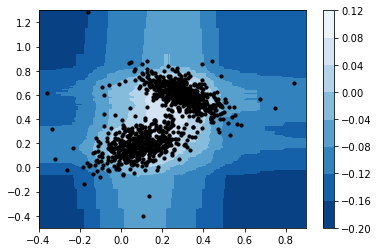

In [48]:
# construct our dataset, now we do not need labels!
X = np.concatenate([X1, X2, X3])

# Isolation Forests
# contamination: percentage of outliers
clf = IsolationForest(max_samples=100, contamination=0.05)
clf.fit(X)

# plot decision boundries 
xx, yy = np.meshgrid(np.linspace(-0.4, 0.9, 500), np.linspace(-0.5, 1.3, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
plt.colorbar()

# plot the acutal objects
plt.scatter(X[:, 0], X[:, 1], c="k", s=10)

### Question to student:
Define the threshold below which an object will be defined as an outlier. <br>
Use different thresholds, what is the best threshold? How can you define it automaticaly? <br>
Use the decision_function to examine these.